# Predict `Subject Age`

In [1]:
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import time
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

In [4]:
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [9,6]

In [5]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [6]:
phenotype = 'Subject Age'

In [7]:
#load data
aging_dir = Path('/home/ubuntu/a/aging/aging')

with open(aging_dir/'aging-cytof-data.obj', 'rb') as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']
# Truncate cytodata
cyto_data = cyto_data[ :, :int(5e3)]
markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 5000, 27, 1)
Dimensions of samples: (260, 85)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


In [8]:
samples.columns

Index(['Subject Accession', 'Species', 'Race', 'Race Specify', 'Ethnicity',
       'Strain', 'Gender', 'Age Event', 'Age Event Specify', 'Subject Age',
       'Age Unit', 'Subject Phenotype', 'ARM Accession', 'ARM Name',
       'Study Accession', 'Study Brief Title', 'Biosample Accession',
       'Biosample Description', 'Biosample Name', 'Biosample Type',
       'Biosample Subtype', 'Study Time Collected',
       'Study Time Collected Unit', 'Study Time T0 Event',
       'Study Time T0 Event Specify', 'Biosample Treatment',
       'Planned Visit Accession', 'Planned Visit Name', 'Experiment Accession',
       'Expsample Accession', 'Expsample Description',
       'Expsample Result Schema', 'Expsample Treatement', 'Reagent Accession',
       'Reagent Name', 'Reagent Reporter Name', 'File Info ID', 'File Detail',
       'File Name', 'Original File Name', 'fcs', 'pkl', 'pkl_exists', 'n_rows',
       'n_columns', 'markers', 'WBC', 'RBC', 'Hemoglobin', 'Hematocrit', 'MCV',
       'MCH', 'M

count    260.000000
mean      68.303846
std       15.169696
min       41.000000
25%       55.000000
50%       69.000000
75%       82.000000
max       90.000000
Name: Subject Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

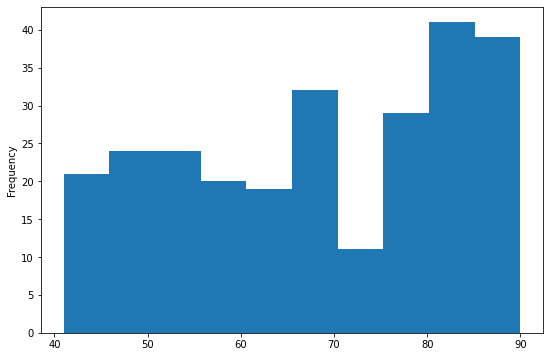

In [9]:
print(samples[phenotype].describe())
samples[phenotype].plot.hist()

In [10]:
blood_start_index = samples.columns.get_indexer(['markers'])[0]+1
xdf = samples.iloc[:, blood_start_index:]
print(xdf.shape)
xdf

(260, 39)


,WBC,RBC,Hemoglobin,Hematocrit,MCV,MCH,MCHC,RDW,NEUT_Pct,LYM_Pct,...,ProteinTotal,AlbuminTotal,TotalBilirubin,AlkalinePhosphataseTotal,AST(SGOT),ALT(SGPT),Globulin,C-ReactiveProtein,PlateletCount,ESR
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.9,4.57,13.0,39.9,87.4,28.4,32.5,16.4,61.4,26.7,...,7.6,3.5,NaN,93.0,19.0,27.0,4.1,3.5,253.0,NaN
4,4.3,4.03,13.4,39.3,97.6,33.1,34.0,13.3,52.6,34.6,...,7.6,4.3,0.6,92.0,23.0,30.0,3.3,0.2,206.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,7.9,4.53,14.0,44.0,97.0,31.0,31.9,16.9,71.8,15.1,...,7.5,3.8,1.1,162.0,30.0,42.0,3.7,0.4,194.0,NaN
256,7.2,4.48,13.8,42.4,94.6,30.9,32.7,13.3,66.5,23.7,...,7.9,3.8,0.5,85.0,20.0,31.0,4.1,0.2,207.0,NaN
257,9.9,3.49,11.1,33.4,95.5,31.9,33.4,15.9,79.8,11.5,...,7.7,3.8,NaN,90.0,24.0,35.0,3.9,0.2,246.0,NaN
258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
xdf = xdf.dropna(axis=0, how='all')
xdf = xdf.dropna(axis=1, thresh=xdf.shape[0]-10)
print(xdf.shape)
xdf

(202, 37)


,WBC,RBC,Hemoglobin,Hematocrit,MCV,MCH,MCHC,RDW,NEUT_Pct,LYM_Pct,...,UreaNitrogen,Calcium,ProteinTotal,AlbuminTotal,AlkalinePhosphataseTotal,AST(SGOT),ALT(SGPT),Globulin,C-ReactiveProtein,PlateletCount
3,5.9,4.57,13.0,39.9,87.4,28.4,32.5,16.4,61.4,26.7,...,15.0,9.7,7.6,3.5,93.0,19.0,27.0,4.1,3.5,253.0
4,4.3,4.03,13.4,39.3,97.6,33.1,34.0,13.3,52.6,34.6,...,19.0,8.9,7.6,4.3,92.0,23.0,30.0,3.3,0.2,206.0
5,3.9,4.60,15.0,43.1,93.6,32.6,34.8,13.1,59.4,32.3,...,15.0,9.3,7.1,3.9,77.0,23.0,33.0,3.2,0.2,252.0
6,5.2,4.07,12.6,38.2,93.9,30.9,33.0,13.4,59.3,26.6,...,13.0,9.1,7.8,3.8,89.0,20.0,27.0,4.0,0.2,226.0
7,5.1,4.56,14.6,44.3,97.0,31.9,32.9,14.0,45.7,36.7,...,18.0,8.8,7.3,4.2,67.0,33.0,42.0,3.1,0.2,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,9.0,4.62,14.0,42.6,92.1,30.4,33.0,14.1,66.7,23.2,...,21.0,9.0,7.5,3.8,114.0,27.0,34.0,3.7,0.4,281.0
255,7.9,4.53,14.0,44.0,97.0,31.0,31.9,16.9,71.8,15.1,...,16.0,9.2,7.5,3.8,162.0,30.0,42.0,3.7,0.4,194.0
256,7.2,4.48,13.8,42.4,94.6,30.9,32.7,13.3,66.5,23.7,...,21.0,9.6,7.9,3.8,85.0,20.0,31.0,4.1,0.2,207.0
257,9.9,3.49,11.1,33.4,95.5,31.9,33.4,15.9,79.8,11.5,...,24.0,8.8,7.7,3.8,90.0,24.0,35.0,3.9,0.2,246.0


In [12]:
xdf.isnull().sum()

WBC                         0
RBC                         0
Hemoglobin                  0
Hematocrit                  0
MCV                         0
MCH                         0
MCHC                        0
RDW                         0
NEUT_Pct                    2
LYM_Pct                     2
MONO_Pct                    2
EOS_Pct                     2
BASO_Pct                    5
TotalCholesterol            1
Triglyceride                0
HDLCholesterol              0
LDLCholesterol              1
Cholesterol_HDLRatio        1
Non-HDLCholesterolcalc      1
LDL_HDLRatio                2
Sodium                      0
Potassium                   0
Chloride                    0
CO2                         0
AnionGap                    0
Glucose                     0
Creatinine                  0
UreaNitrogen                0
Calcium                     0
ProteinTotal                0
AlbuminTotal                0
AlkalinePhosphataseTotal    0
AST(SGOT)                   0
ALT(SGPT) 

In [13]:
ydf = samples[phenotype][xdf.index]
ydf.shape

(202,)

In [14]:
age_range = max(ydf) - min(ydf)

x_train, x_valid, y_train, y_valid = train_test_split(xdf, ydf)

y_scaler = StandardScaler()
y_train = np.asarray(y_train)
y_valid = np.asarray(y_valid)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1)).reshape(1,-1)[0]
y_valid = y_scaler.transform(y_valid.reshape(-1,1)).reshape(1,-1)[0]

imputer = SimpleImputer()
x_train = imputer.fit_transform(x_train)
x_valid = imputer.transform(x_valid)

x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_valid = x_scaler.transform(x_valid)

In [15]:
model = Sequential([
    Input(shape=x_train[0].shape),
#     Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
#     Dense(16, activation='relu'),
    Dense(1),
])
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_absolute_error',]
             )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2432      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [16]:
%%time
model_store = Path(f'Result/saved_weights_{phenotype}.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(filepath=model_store, 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=20,
          epochs=50, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/50
8/8 [==============================] - 3s 20ms/step - loss: 1.0616 - mean_absolute_error: 0.8685 - val_loss: 0.8966 - val_mean_absolute_error: 0.8267
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.7982 - mean_absolute_error: 0.7785 - val_loss: 0.7626 - val_mean_absolute_error: 0.7507
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6407 - mean_absolute_error: 0.6845 - val_loss: 0.7547 - val_mean_absolute_error: 0.7298
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4997 - mean_absolute_error: 0.5868 - val_loss: 0.7546 - val_mean_absolute_error: 0.7067
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4168 - mean_absolute_error: 0.5250 - val_loss: 0.6862 - val_mean_absolute_error: 0.6666
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.3405 - mean_absolute_error: 0.4709 - val_loss: 0.6317 - val_mean_absolute_error: 0.6482
Epoch 7/50
8/8 [=======================

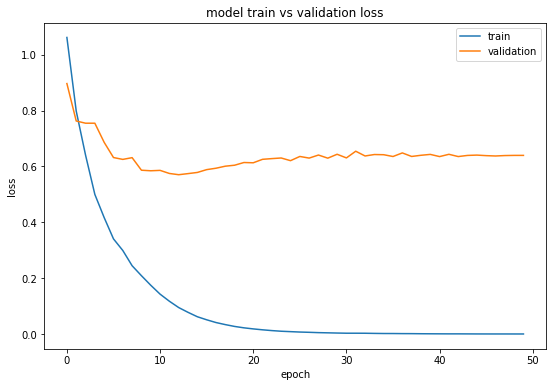

In [17]:
##### Step 6: plot train and validation loss #####
history = model.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [18]:
##### Step 6: plot train and validation loss #####
plt.plot(unscale_vec(y_scaler, history.history['mean_absolute_error']))
plt.plot(unscale_vec(y_scaler, history.history['val_mean_absolute_error']))
plt.title('model train vs validation error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

NameError: name 'unscale_vec' is not defined

In [19]:
#### Step 7: test the final model #####
final_model = load_model(model_store)
x_test = x_valid
y_test = y_valid
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])
vals_true = pd.Series(y_scaler.inverse_transform(y_valid.reshape(-1,1)).reshape(1,-1)[0])
vals_pred = pd.Series(y_scaler.inverse_transform(y_scores.reshape(-1,1)).reshape(1,-1)[0])
errors = vals_pred - vals_true
errors.describe()

count    51.000000
mean      1.463322
std      11.696999
min     -23.120937
25%      -4.602219
50%       0.331863
75%       8.797325
max      28.316360
dtype: float64

[ 0.40439945 41.21673901]


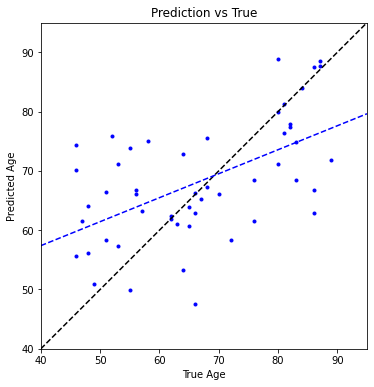

In [20]:
plt.plot(vals_true, vals_pred,'b.')
plt.axis('square')
plt.xlim((40,95))
plt.ylim((40,95))
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Prediction vs True')
plt.plot([40,95],[40,95],'--k')
coef = np.polyfit(vals_true, vals_pred, 1)
print(coef)
poly1d_fn = np.poly1d(coef)
plt.plot([40,95], poly1d_fn([40,95]), '--b')
plt.show()

count    51.000000
mean      1.463322
std      11.696999
min     -23.120937
25%      -4.602219
50%       0.331863
75%       8.797325
max      28.316360
dtype: float64


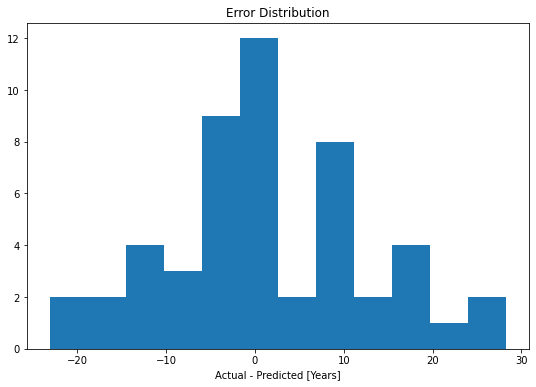

In [21]:
print(errors.describe())
plt.hist(errors, bins=int((errors.max()-errors.min())/4))
plt.title('Error Distribution')
plt.xlabel('Actual - Predicted [Years]')
plt.show()

count    51.000000
mean      8.942450
std       7.578730
min       0.004852
25%       1.966309
50%       7.624809
75%      14.514008
max      28.316360
dtype: float64


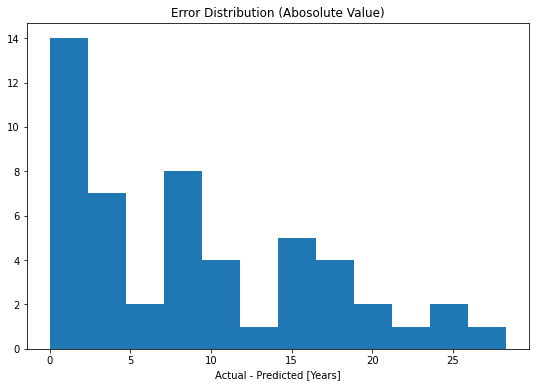

In [22]:
print(errors.abs().describe())
plt.hist(errors.abs(), bins=int((errors.max()-errors.min())/4))
plt.title('Error Distribution (Abosolute Value)')
plt.xlabel('Actual - Predicted [Years]')
plt.show()

In [23]:
from sklearn.inspection import permutation_importance
imp = permutation_importance(final_model, x_valid, y_valid, scoring='neg_mean_absolute_error', n_repeats=10)
print(list(imp.keys()))

['importances_mean', 'importances_std', 'importances']


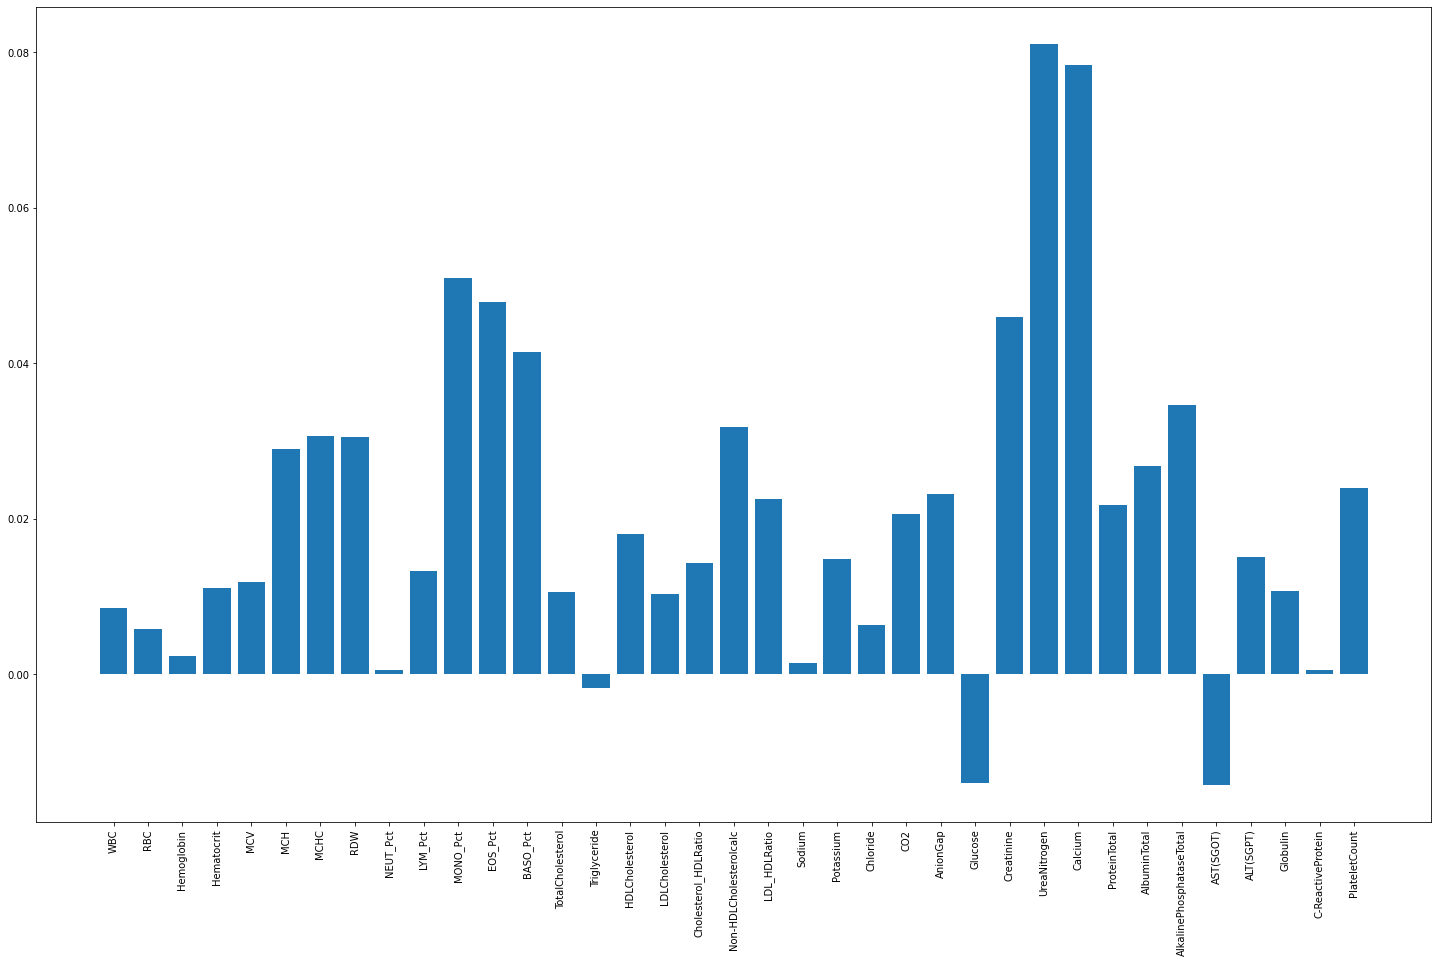

In [24]:
plt.figure(figsize=(25,15))
plt.bar(range(xdf.shape[1]), imp['importances_mean'], tick_label=xdf.columns)
plt.xticks(rotation=90)
plt.show()